In [29]:
from enum import EnumType, Enum

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from numpy.f2py.auxfuncs import throw_error
from pettingzoo.mpe import simple_push_v3


def make_env():
    env = simple_push_v3.parallel_env(continuous_actions=False, render_mode="rgb_array", max_cycles=25)
    env.reset()
    return env

def make_env_human():
    env = simple_push_v3.parallel_env(continuous_actions=False, render_mode="human", max_cycles=25)
    env.reset()
    return env

class DiscType(Enum):
    DECENTRALIZED = "decentralized"
    CENTRALIZED = "centralized"
    SINGLE = "single"


# Test the Environment

In [30]:
env = make_env()
observations, infos = env.reset()  # returns a dict
observations
# env.action_space

{'adversary_0': array([ 0.        ,  0.        , -1.0214212 ,  1.672851  ,  0.23687497,
        -0.06824502, -0.19726226,  1.6586812 ], dtype=float32),
 'agent_0': array([ 0.        ,  0.        , -0.8241589 ,  0.01416978,  0.25      ,
         0.75      ,  0.25      , -0.8241589 ,  0.01416978,  0.43413723,
        -1.7269262 ,  0.1       ,  0.9       ,  0.1       ,  0.1       ,
         0.1       ,  0.9       ,  0.19726226, -1.6586812 ], dtype=float32)}

**Here we can see that the global state is a concatenation of local observations**

In [31]:
env.state()

array([ 0.        ,  0.        , -1.0214212 ,  1.672851  ,  0.23687497,
       -0.06824502, -0.19726226,  1.6586812 ,  0.        ,  0.        ,
       -0.8241589 ,  0.01416978,  0.25      ,  0.75      ,  0.25      ,
       -0.8241589 ,  0.01416978,  0.43413723, -1.7269262 ,  0.1       ,
        0.9       ,  0.1       ,  0.1       ,  0.1       ,  0.9       ,
        0.19726226, -1.6586812 ], dtype=float32)

In [32]:
print("Agents:", env.agents)  # ['speaker_0', 'listener_0']

Agents: ['adversary_0', 'agent_0']


# Hyperparameters

Simple push

This environment has 1 good agent, 1 adversary, and 1 landmark. The good agent is rewarded based on the distance to the landmark. The adversary is rewarded if it is close to the landmark, and if the agent is far from the landmark (the difference of the distances). Thus the adversary must learn to push the good agent away from the landmark.

In [33]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

USE_KFAC = False

DISC_TYPE = DiscType.DECENTRALIZED
total_training_runs = 3
training_epochs = 1000

centralized_learning_rate = 5e-4 # Try 3e-4
centralized_weight_decay = 0.2

decentralized_learning_rate = 1e-3
decentralized_weight_decay = 1e-3

policy_learning_rate = 1e-3
policy_learning_rate_kfac = 1e-2

value_learning_rate = 1e-3

num_expert_episodes = 200
BATCH_SIZE = 64
PPO_EPOCHS = 10
PPO_CLIP = 0.1
ENTROPY_COEF = 0

# Two layers network, applied for discriminator, policy and value network
all_hid_dim = 128




# Environment Variables

In [34]:
# Agent dimensions
adversary_obs_dim = 8
agent_obs_dim = 19

adversary_act_dim = 5
agent_act_dim = 5 # [no_action, move_left, move_right, move_down, move_up]

# Two layers network, applied for discriminator, policy and value network
all_hid_dim = 128

all_agents = env.agents

obs_dims = {
    "adversary_0": adversary_obs_dim,
    "agent_0": agent_obs_dim
}

act_dims = {
    "adversary_0": adversary_act_dim,
    "agent_0": agent_act_dim
}

hid_dims = {
    "adversary_0": all_hid_dim,
    "agent_0": all_hid_dim
}

# Evaluated from 5000 expert episodes
expert_mean_reward = -12

EXPERT_AGENT_REWARDS = {'adversary_0': np.float64(-3.15), 'agent_0': np.float64(-7.34)}

# Expert Demonstrations
Load the expert policy from paper Inverse Factorized Soft Q-Learning for Cooperative Multi-agent Imitation Learning


In [35]:
def convert_decentralized_data_to_centralized(decentralized_data):
    """
    Converts decentralized expert data to centralized format.

    Args:
        decentralized_data (dict): Decentralized expert data with the structure:
            {
                agent1: {"states": [state1, state2, ...], "actions": [action1, action2, ...]},
                agent2: {"states": [state1, state2, ...], "actions": [action1, action2, ...]},
                ...
            }
    Returns:
        dict: Centralized expert data with the structure:
            {
                "global_states": [state1, state2, ...],
                "joint_actions": [actions1, actions2, ...],
            }
    """
    centralized_expert_data = {
        "joint_states": [],  # Global states across all agents
        "joint_actions": []   # Joint actions per global state
    }

    # Ensure we use the same length throughout agents
    num_samples = len(decentralized_data[all_agents[0]]["states"])  # Extract the length from first agent

    for i in range(num_samples):
        # Combine states of all agents into a global state
        global_state = []
        for agent in decentralized_data:
            global_state.extend(decentralized_data[agent]["states"][i])
        centralized_expert_data["joint_states"].append(global_state)

        # Collect actions from all agents into a joint action
        joint_action = [decentralized_data[agent]["actions"][i] for agent in decentralized_data]
        centralized_expert_data["joint_actions"].append(joint_action)

    return centralized_expert_data


In [36]:
import pickle

with open("Expert_data/expert_data_rllib_simple_push_200.pickle", "rb") as f:
    decentralized_expert_data = pickle.load(f)

In [37]:
# Generate data

if DISC_TYPE == DiscType.CENTRALIZED:
    centralized_expert_data = convert_decentralized_data_to_centralized(decentralized_expert_data)


In [38]:
decentralized_expert_data["agent_0"]["states"][0]

array([ 0.        ,  0.        , -0.3716264 , -1.0369922 ,  0.25      ,
        0.75      ,  0.25      , -0.3716264 , -1.0369922 ,  0.46976086,
       -0.0733379 ,  0.1       ,  0.9       ,  0.1       ,  0.1       ,
        0.1       ,  0.9       ,  0.05389906, -1.7238958 ], dtype=float32)

In [39]:
decentralized_expert_data["agent_0"]["states"][0]

array([ 0.        ,  0.        , -0.3716264 , -1.0369922 ,  0.25      ,
        0.75      ,  0.25      , -0.3716264 , -1.0369922 ,  0.46976086,
       -0.0733379 ,  0.1       ,  0.9       ,  0.1       ,  0.1       ,
        0.1       ,  0.9       ,  0.05389906, -1.7238958 ], dtype=float32)

In [40]:
centralized_expert_data = convert_decentralized_data_to_centralized(decentralized_expert_data)
centralized_expert_data["joint_states"][0]

[np.float32(0.0),
 np.float32(0.0),
 np.float32(-0.4255255),
 np.float32(0.6869036),
 np.float32(0.4158618),
 np.float32(1.6505579),
 np.float32(-0.053899065),
 np.float32(1.7238958),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(-0.3716264),
 np.float32(-1.0369922),
 np.float32(0.25),
 np.float32(0.75),
 np.float32(0.25),
 np.float32(-0.3716264),
 np.float32(-1.0369922),
 np.float32(0.46976086),
 np.float32(-0.0733379),
 np.float32(0.1),
 np.float32(0.9),
 np.float32(0.1),
 np.float32(0.1),
 np.float32(0.1),
 np.float32(0.9),
 np.float32(0.053899065),
 np.float32(-1.7238958)]

Shape Checking

In [41]:
if DISC_TYPE == DiscType.CENTRALIZED:
    expert_states = torch.FloatTensor(centralized_expert_data["joint_states"]).to(device)
    expert_actions = torch.LongTensor(centralized_expert_data["joint_actions"]).to(device)
elif DISC_TYPE == DiscType.DECENTRALIZED:
    agent = "agent_0"
    expert_states = torch.FloatTensor(decentralized_expert_data[agent]["states"]).to(device)
    expert_actions = torch.LongTensor(decentralized_expert_data[agent]["actions"]).to(device)


In [42]:
expert_states.shape

torch.Size([9800, 19])

In [43]:
expert_actions.shape

torch.Size([9800])

In [44]:
expert_actions.cpu().numpy()

array([3, 3, 3, ..., 2, 1, 2], shape=(9800,))

### Evaluate the Expert Policy

In [45]:
def evaluate_policy_for_expert(policy_func, num_episodes=50, threshold=0.1, h_dim=128, device=device):
    env = make_env()
    avg_rewards = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0
        rnn_actor = torch.zeros((2, 1, h_dim), device=device)

        while env.agents:
            actions, rnn_actor = policy_func(obs, rnn_actor, deterministic=True)
            obs, rewards, done, _, _ = env.step(actions)
            total_reward += sum(rewards.values())

        avg_rewards.append(total_reward)

    env.close()
    return {
        "avg_reward": np.mean(avg_rewards),
    }


In [46]:
# Evaluate the expert policy
# expert_eval = evaluate_policy_for_expert(expert_policy, num_episodes=20)
# print("Expert Policy Evaluation:", expert_eval)


# Policy Evaluation Function

In [47]:
def learned_policy(policies, obs, device=device):
    """
    Retrieves actions from the learned policy networks for both agents based on observations.

    Args:
        policies (dict): Dictionary mapping agent names to their Policy network instances.
        obs (dict): Dictionary of observations for each agent.
        device (str): Device to perform computations on ("cuda:0" or "cpu").

    Returns:
        dict: Dictionary mapping agent names to selected actions.
    """
    actions = {}
    for agent in obs:
        policy = policies[agent]
        # Convert observation to tensor and move to device
        obs_tensor = torch.FloatTensor(obs[agent]).to(device)
        with torch.no_grad():
            # Get action probabilities from the policy network
            action_probs = policy(obs_tensor)
            # Select the action with the highest probability
            action = torch.argmax(action_probs).item()
        actions[agent] = action
    return actions

def evaluate_policy_for_training(policies, num_episodes=50, threshold=0.1, device=device):
    """
    Evaluates the performance of learned policies over multiple episodes.

    Args:
        policies (dict): Dictionary of Policy networks for each agent.
        num_episodes (int): Number of episodes to run for evaluation (default: 50).
        threshold (float): Distance threshold to determine success (default: 0.1).
        device (str): Device to perform computations on (default: "cuda:0" or "cpu").

    Returns:
        dict: Dictionary containing evaluation metrics:
              - "success_rate": Mean success rate across episodes.
              - "avg_reward": Mean total reward per episode.
              - "avg_steps": Mean number of steps per episode.
    """
    # Set to evaluation mode to switch off dropout
    for policy in policies.values():
        policy.eval()

    # Initialize the environment
    env = make_env()
    avg_rewards = []

    # Run evaluation over specified number of episodes
    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0

        # Run the episode
        while env.agents:
            # Get actions using the learned policy
            actions = learned_policy(policies, obs, device)
            # Step the environment
            obs, rewards, done, _, _ = env.step(actions)
            total_reward += sum(rewards.values())  # Sum rewards from both agents

        avg_rewards.append(total_reward)

    # Clean up environment resources
    env.close()

    # Compute and return average metrics
    return {
        "avg_reward": np.mean(avg_rewards),
    }

# MAGAIL Training

## Define MAGAIL Networks

In [48]:
import torch
import torch.nn as nn

# Define the Xavier initialization function
def init_weights_xavier(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

# Policy Networks (one per agent)
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, act_dim),
            nn.Softmax(dim=-1)
        )
        self.apply(init_weights)
    
    def forward(self, x):
        return self.net(x)

# Discriminator Networks (one per agent)
# Output the probability of (s,a) Coming from the EXPERT
class Discriminator(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
        self.apply(init_weights)
    
    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=-1))
    
# Value Network as baseline
class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.apply(init_weights)
    
    def forward(self, x):
        return self.net(x)


def init_networks():
    # Initialize Networks

    if DISC_TYPE == DiscType.CENTRALIZED:
        # For Discriminator the output is a single value
        joint_state_dim = sum(obs_dims.values())  # Global state dimension
        joint_action_dim = sum(act_dims.values())
        discriminator_centralized = Discriminator(obs_dim=joint_state_dim, act_dim=joint_action_dim, hidden_dim=hid_dims[all_agents[0]]).to(device)

    elif DISC_TYPE == DiscType.DECENTRALIZED:
        discriminators = {
            a: Discriminator(obs_dim=obs_dims[a], act_dim=act_dims[a], hidden_dim=hid_dims[a]).to(device)
            for a in all_agents
        }

    # Initialize value networks to reduce variance (actor critic)

    policies = {
        a: Policy(obs_dim=obs_dims[a], act_dim=act_dims[a], hidden_dim=hid_dims[a]).to(device)
        for a in all_agents
    }

    if DISC_TYPE == DiscType.CENTRALIZED:
        joint_state_dim = sum(obs_dims.values())  # Global state dimension
        value_nets = {}
        for agent in all_agents:
            value_nets[agent] = ValueNet(joint_state_dim, hid_dims[agent]).to(device)
    elif DISC_TYPE == DiscType.DECENTRALIZED:
        value_nets = {
            agent: ValueNet(obs_dims[agent], hid_dims[agent]).to(device)
            for agent in all_agents
        }

    if DISC_TYPE == DiscType.CENTRALIZED:
        return discriminator_centralized, value_nets, policies
    elif DISC_TYPE == DiscType.DECENTRALIZED:
        return discriminators, value_nets, policies

In [49]:
sum(act_dims.values())

10

## Training MAGAIL Loop

In [50]:
from torch_kfac import KFAC

def train_magail(expert_data, num_epochs=1000, batch_size=32):


    # TODO Change this into an object
    training_data = {
        'expert_rewards': [],
        'episode_rewards': [],
        'generator_rewards': [],
        'advantages': [],
        'value_estimates': [],
        'policy_losses': [],
        'disc_real_prob': [],
        'disc_fake_prob': []
    }

    discriminator, value_nets, policies = init_networks()
    optimizers = init_optimizers(discriminator, value_nets, policies)

    for epoch in range(num_epochs):

        decentralized_policy_data = collect_policy_trajectories(policies, batch_size=batch_size)
        centralized_policy_data = convert_decentralized_data_to_centralized(decentralized_policy_data)

        # --- Update discriminators ---
        real_prob, fake_prob = update_discriminators(discriminator, centralized_policy_data, decentralized_policy_data, optimizers, batch_size)

        # --- Update policies and value (Actor Critic) ---
        generator_rewards, advantages, value_loss, policy_loss = update_policies(discriminator, value_nets, policies, decentralized_policy_data, centralized_policy_data, optimizers, batch_size)

        # Diagnostic
        record_and_print_diagnostics(epoch, policies, training_data, generator_rewards, advantages, value_loss, policy_loss, real_prob, fake_prob)


    env.close()

    return training_data

def init_optimizers(discriminator, value_nets, policies):
    if USE_KFAC:
        optimizers = {
        agent: {
            # Replace Adam with KFAC for policy
            "policy": KFAC(
                policies[agent],
                learning_rate=policy_learning_rate_kfac,  # Typically larger than Adam
                damping=1e-2,           # Added to the curvature approximation (Fisher matrix) for numerical stability.  lower damping → lower learning_rate
                momentum=0.95,# Similar to Nesterov momentum
                momentum_type='regular',
                norm_constraint=0.002,       # For KL ≤ 0.001
                cov_ema_decay=0.95,
                adapt_damping=True,     # Let KFAC adjust damping
                update_cov_manually=True  # Required for control
            ),
            "value": torch.optim.Adam(value_nets[agent].parameters(), lr=value_learning_rate)
            } for agent in all_agents
        }

    else:
        optimizers = {
        agent: {
            # Replace Adam with KFAC for policy
            "policy": torch.optim.Adam(policies[agent].parameters(), lr=policy_learning_rate),
            "value": torch.optim.Adam(value_nets[agent].parameters(), lr=value_learning_rate)
            } for agent in all_agents
        }

    if DISC_TYPE == DiscType.CENTRALIZED:
        optimizers["disc"] = torch.optim.Adam(discriminator.parameters(), lr=centralized_learning_rate, weight_decay=centralized_weight_decay)
    elif DISC_TYPE == DiscType.DECENTRALIZED:
        for agent in all_agents:
            optimizers[agent]["disc"] = torch.optim.Adam(discriminator[agent].parameters(), lr=decentralized_learning_rate, weight_decay=decentralized_weight_decay)

    # for agent in all_agents:
    #     policies[agent].to(device)
    return optimizers

#region Data sample and processing

def collect_policy_trajectories(policies, batch_size=32):
    env = make_env()
    policy_data = {
        agent: {
            "states": [],
            "actions": [],
            "log_prob": [],
            "reward": [],
            "next_state": []
        }
        for agent in env.agents
    }
    obs, _ = env.reset()
    agent = env.agents[0]
    policy_data_length = len(policy_data[agent]["states"])
    while policy_data_length < batch_size:
        while env.agents:
            actions = {}
            for agent in env.agents:
                with torch.no_grad():
                    obs_tensor = torch.FloatTensor(obs[agent]).to(device)
                    action_probs = policies[agent](obs_tensor)

                # Add numerical stability checks
                if torch.isnan(action_probs).any() or (action_probs < 0).any():
                    print("Invalid action probabilities detected!")
                    action_probs = torch.softmax(action_probs, dim=-1)  # Force normalization
                    action_probs = torch.clamp(action_probs, min=1e-5, max=1-1e-5)

                # Simpling by probability - ensure exploration
                # Similar with Epsilon-Greedy, but used in policy-based algorithms. Epsilon-Greedy is in valued based
                action = torch.multinomial(action_probs, 1).item()
                actions[agent] = action

                # Data collection
                policy_data[agent]["states"].append(obs[agent])
                policy_data[agent]["actions"].append(action)
                log_prob = torch.log(action_probs[action].clamp(min=1e-8))
                policy_data[agent]["log_prob"].append(log_prob)

            obs, rewards, terminations, truncations, infos= env.step(actions)

            for agent in env.agents:

                # with torch.no_grad():
                    ## Decentralized
                    # TODO encode action
                    # reward = torch.log(discriminators[agent](torch.FloatTensor(obs[agent]).to(device), torch.LongTensor(actions[agent]).to(device)))

                # policy_data[agent]["reward"].append(reward)

                if not terminations[agent]:
                    policy_data[agent]["next_state"].append(obs[agent])
                else:
                    policy_data[agent]["next_state"].append(None)

        env.reset()
        policy_data_length = len(policy_data[agent]["states"])

    return policy_data

def sample_batch_state_action_pairs(disc_type : DiscType, data, batch_size=32, agent = None, include_log_prob=False):

    # Sample Expert data
    if disc_type == DiscType.CENTRALIZED:
        states = torch.FloatTensor(data["joint_states"]).to(device)
        actions = torch.LongTensor(data["joint_actions"]).to(device)
        if include_log_prob:
            log_probs = torch.stack(data[agent]["log_prob"]).to(device)
    elif disc_type == DiscType.DECENTRALIZED:
        if not agent:
            throw_error("Please specify the agent in DECENTRALIZED mode")
        states = torch.FloatTensor(data[agent]["states"]).to(device)
        actions = torch.LongTensor(data[agent]["actions"]).to(device)
        if include_log_prob:
            log_probs = torch.stack(data[agent]["log_prob"]).to(device)

    # Make sure the (s,a) order does not change
    sample_indices = np.random.choice(len(states), batch_size, replace=False)
    batch_states = states[sample_indices]
    batch_actions = actions[sample_indices]

    if include_log_prob:
        batch_old_log_probs = log_probs[sample_indices]
        return batch_states, batch_actions, batch_old_log_probs

    return batch_states, batch_actions

def encode_joint_actions(joint_actions):
    '''
    Convert joint actions to one-hot
    action [2,4] => [0,0,1,0,0,0,0,1] joint actions one hot
    action [2,3] => [0,0,1,0,0,0,1,0]
    :param joint_actions:
    :return:
    '''
    encoded = []
    for ja in joint_actions:
        speaker_act = torch.nn.functional.one_hot(torch.tensor(ja[0]), adversary_act_dim)
        listener_act = torch.nn.functional.one_hot(torch.tensor(ja[1]), agent_act_dim)
        encoded.append(torch.cat([speaker_act, listener_act]))
    return torch.stack(encoded).to(device)
#endregion

#region discriminators Networks

def update_discriminators(discriminator, centralized_policy_data, decentralized_policy_data, optimizers, batch_size):
    if DISC_TYPE == DiscType.CENTRALIZED:
        real_prob, fake_prob = update_discriminators_centralized(discriminator, centralized_expert_data, centralized_policy_data, optimizers, batch_size)
    elif DISC_TYPE == DiscType.DECENTRALIZED:
        for agent in all_agents:
           real_prob, fake_prob =  update_discriminators_decentralized(discriminator, agent, decentralized_expert_data, decentralized_policy_data, optimizers, batch_size)

    return real_prob, fake_prob

def update_discriminators_decentralized(discriminator, agent, expert_data, policy_data, optimizers, batch_size):
    # Sample batch from dataset
    expert_states, expert_actions = sample_batch_state_action_pairs(DISC_TYPE, expert_data, batch_size, agent)
    policy_states, policy_actions = sample_batch_state_action_pairs(DISC_TYPE, policy_data, batch_size, agent)

    # One-hot encode actions (different for speaker/listener)
    num_classes = act_dims[agent]
    expert_actions_onehot = torch.nn.functional.one_hot(expert_actions, num_classes=num_classes).float().to(device)
    policy_actions_onehot = torch.nn.functional.one_hot(policy_actions, num_classes=num_classes).float().to(device)

    expert_prob, policy_prob = discriminator_backward(discriminator[agent], optimizers[agent]["disc"], expert_states, expert_actions_onehot, policy_states, policy_actions_onehot)

    return expert_prob, policy_prob

def update_discriminators_centralized(discriminator, centralized_expert_data, centralized_policy_data, optimizers, batch_size):
    # Centralized update
    # Shape [batch_size, 14], [batch_size, 2]
    expert_joint_states, expert_joint_actions = sample_batch_state_action_pairs(DISC_TYPE, centralized_expert_data, batch_size)
    policy_joint_states, policy_joint_actions = sample_batch_state_action_pairs(DISC_TYPE, centralized_policy_data, batch_size)

    expert_joint_actions_onehot = encode_joint_actions(expert_joint_actions)
    policy_joint_actions_onehot = encode_joint_actions(policy_joint_actions)

    expert_prob, policy_prob = discriminator_backward(discriminator, optimizers["disc"], expert_joint_states, expert_joint_actions_onehot, policy_joint_states, policy_joint_actions_onehot)

    return expert_prob, policy_prob

def discriminator_backward(discriminator, discriminator_optimizer, expert_states, expert_actions_onehot, policy_states, policy_actions_onehot):

    # Discriminator loss
    # max[log(D(expert)) + log(1 - D(policy))] => min[-log(D(expert)) - log(1 - D(policy))],

    expert_prob = discriminator(expert_states, expert_actions_onehot)
    policy_prob = discriminator(policy_states, policy_actions_onehot)

    real_loss = -torch.log(expert_prob).mean()
    fake_loss = -torch.log(1 - policy_prob).mean()
    disc_loss = real_loss + fake_loss

    discriminator_optimizer.zero_grad()
    disc_loss.backward()
    discriminator_optimizer.step()

    return expert_prob, policy_prob

#endregion

#region Policy and Value Networks
def update_policies(discriminator, value_nets, policies, decentralized_policy_data, centralized_policy_data, optimizers, batch_size):
    for agent in all_agents:
        if USE_KFAC:
            optimizers[agent]["policy"].update_cov()
        if DISC_TYPE == DiscType.CENTRALIZED:
            generator_rewards, advantages, value_loss, policy_loss = update_policies_centralized(discriminator, value_nets, policies, agent, decentralized_policy_data, centralized_policy_data, optimizers, batch_size)
        elif DISC_TYPE == DiscType.DECENTRALIZED:
            generator_rewards, advantages, value_loss, policy_loss = update_policies_decentralized(discriminator, value_nets, policies, agent, decentralized_policy_data, optimizers, batch_size)

    return  generator_rewards, advantages, value_loss, policy_loss

def update_policies_centralized(discriminator, value_nets, policies, agent, decentralized_policy_data, centralized_policy_data, optimizers, batch_size):

    # Centralized data
    policy_joint_states, policy_joint_actions = sample_batch_state_action_pairs(DISC_TYPE, centralized_policy_data, batch_size)
    policy_joint_actions_onehot = encode_joint_actions(policy_joint_actions)# actions [0,0] => [1,0,0,1,0,0,0,0]

    # decentralized data
    policy_states, policy_actions, old_log_probs = sample_batch_state_action_pairs(disc_type= DiscType.DECENTRALIZED, data=decentralized_policy_data, batch_size=batch_size, agent=agent, include_log_prob=True)

    # Adversarial reward: log(D(s,a))
    # D(s,a) How much the descrimiator think it is from the expert, and we wanna maximize this reward
    with torch.no_grad():

        # MAGAIL paper section 4.1
        # Implicitly, Di - discriminators plays the role of a reward function for the generator,which in turn attempts to train the agent to maximize its reward thus fooling the discriminator
        # In centralized case, this input the joint state actions
        generator_rewards = torch.log(discriminator(policy_joint_states, policy_joint_actions_onehot)) # Shape [batch_size,1]

        # Compute value baseline
        values = value_nets[agent](policy_joint_states) # Shape [batch_size,1]


    advantages, policy_loss = update_value_and_policy_network(policies, agent, optimizers, generator_rewards, values, policy_states, policy_actions, old_log_probs)
    return generator_rewards, advantages, values.mean(), policy_loss

def update_policies_decentralized(discriminator, value_nets, policies, agent, policy_data, optimizers, batch_size):
    policy_states, policy_actions, old_log_probs = sample_batch_state_action_pairs(disc_type= DiscType.DECENTRALIZED, data=policy_data, batch_size=batch_size, agent=agent, include_log_prob=True)
    # One-hot encode actions (different for speaker/listener)
    num_classes = act_dims[agent]
    policy_actions_onehot = torch.nn.functional.one_hot(policy_actions, num_classes=num_classes).float().to(device)

    # Adversarial reward: log(D(s,a))
    # D(s,a) How much the descrimiator think it is from the expert, and we wanna maximize this reward
    with torch.no_grad():

        # MAGAIL paper section 4.1
        # Implicitly, Di - discriminators plays the role of a reward function for the generator,which in turn attempts to train the agent to maximize its reward thus fooling the discriminator
        # In decentralized case, this input the local observations and agent's actions
        generator_rewards = torch.log(discriminator[agent](policy_states, policy_actions_onehot))

        # Compute value baseline
        values = value_nets[agent](policy_states)

    advantages, policy_loss = update_value_and_policy_network(policies, agent, optimizers, generator_rewards, values, policy_states, policy_actions, old_log_probs)

    return generator_rewards, advantages, values.mean(), policy_loss

def update_value_and_policy_network(policies, agent, optimizers, generator_rewards, values, decentralized_policy_states, decentralized_policy_actions, old_log_probs):

    # Compute advantages
    # TD error: (actual reward - estimate(baseline))
    # Then use this advantage as reward/reinforce signal
    # squeeze() function removes "trivia" dim (dimensions of size 1) form tensor's shape
    # Here values shape [batch_size, 1] => values.squeeze() => [batch_size] it become a vector
    # It can only apply on dimensions of size 1, eg: policy_actions shape [batch_size,2] policy_actions.squeeze().shape is till [batch_size,2]
    advantages = generator_rewards - values # Shape [batch_size,1]
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8) # Normalize advantage

    # Update value network (MSE Loss)
    value_loss = (advantages).pow(2).mean()
    # Should always clear the gradient before update
    value_loss.requires_grad = True
    optimizers[agent]["value"].zero_grad()
    value_loss.backward()
    optimizers[agent]["value"].step()

    if USE_KFAC:
        # --- KFAC Policy gradient ---
        policy_optimizer = optimizers[agent]["policy"]

        # Track forward pass
        with policy_optimizer.track_forward():
            action_probs = policies[agent](decentralized_policy_states)
            log_probs = torch.log(action_probs.gather(1, decentralized_policy_actions.unsqueeze(1)))
            policy_loss = -(log_probs * advantages.detach()).mean()

        # Track backward pass
        with policy_optimizer.track_backward():
            policy_loss.backward()

        # KFAC update steps
        policy_optimizer.update_cov()  # Update curvature approximation
        policy_optimizer.step(loss=policy_loss)  # Precondition gradients

        # In KFAC, the gradient can explode, causing softmax logits to underflow/overflow
        # Use clipping as a safeguard
        torch.nn.utils.clip_grad_norm_(policies[agent].parameters(), max_norm=0.5)
    else:

        # PPO Policy update with multiple epochs
        policy_loss_total = 0.0
        for _ in range(PPO_EPOCHS):
            action_probs = policies[agent](decentralized_policy_states)  # [batch_size, act_dim]
            new_log_probs = torch.log(
                action_probs.gather(1, decentralized_policy_actions.unsqueeze(1)).clamp(min=1e-8)
            ).squeeze(1)  # [batch_size]

            # Instead of directly compute new_log_probs/old_log_probs, we took log and use e to ensure Numerical Stability
            # Cuz in Deep RL action probs can be very small.
            ratio = torch.exp(new_log_probs - old_log_probs)  # [batch_size]

            # for r in ratio:
            #     if r > 1 + PPO_CLIP or r < 1 - PPO_CLIP:
            #         print(f"PPO ratio clipped!! : {r}")

            # TODO While this kind of clipping goes a long way towards ensuring reasonable policy updates, it is still possible to end up with a new policy which is too far from the old policy, and there are a bunch of tricks used by different PPO implementations to stave this off. In our implementation here, we use a particularly simple method: early stopping. If the mean KL-divergence of the new policy from the old grows beyond a threshold, we stop taking gradient steps.

            # PPO clipped surrogate objective
            surr1 = ratio * advantages.detach().squeeze()
            surr2 = torch.clamp(ratio, 1 - PPO_CLIP, 1 + PPO_CLIP) * advantages.detach().squeeze()
            policy_loss = -torch.min(surr1, surr2).mean()

            # Add entropy bonus for exploration
            # entropy = -torch.sum(action_probs * torch.log(action_probs.clamp(min=1e-8)), dim=-1).mean()
            # policy_loss = policy_loss - ENTROPY_COEF * entropy

            optimizers[agent]["policy"].zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(policies[agent].parameters(), max_norm=0.5)  # Gradient clipping
            optimizers[agent]["policy"].step()

            policy_loss_total += policy_loss.item()

        policy_loss_avg = policy_loss_total / PPO_EPOCHS

    return advantages, torch.tensor(policy_loss_avg)

#endregion

def record_and_print_diagnostics(epoch, policies, training_data, generator_rewards, advantages, value_loss, policy_loss, real_prob, fake_prob):
    training_data["generator_rewards"].append(generator_rewards.detach().cpu().numpy().mean())
    training_data["advantages"].append(advantages.detach().cpu().numpy().mean())
    training_data["value_estimates"].append(value_loss.detach().cpu().numpy().mean())
    training_data["policy_losses"].append(policy_loss.detach().cpu().numpy().mean())

    training_data["disc_real_prob"].append(real_prob.detach().cpu().numpy().mean())
    training_data["disc_fake_prob"].append(fake_prob.detach().cpu().numpy().mean())

    if epoch % 50 == 0:
        print("------------------------------------------------------")
        training_eval_stats = evaluate_policy_for_training(policies, num_episodes=20)
        print(f"Epoch {epoch}: Avg Reward={training_eval_stats['avg_reward']:.2f}")
        training_data["episode_rewards"].append(training_eval_stats["avg_reward"])

        # expert_eval = evaluate_policy_for_expert(expert_policy, num_episodes=20)
        training_data["expert_rewards"].append(expert_mean_reward)
        print(f"Expert Policy: Avg Reward={expert_mean_reward}")

        mean_generator_rewards = np.mean(training_data["generator_rewards"][-50:])
        mean_advantages = np.mean(training_data["generator_rewards"][-50:])
        mean_value_losses = np.mean(training_data["value_estimates"][-50:])
        mean_policy_losses = np.mean(training_data["policy_losses"][-50:])
        mean_disc_real_prob = np.mean(training_data["disc_real_prob"][-50:])
        mean_disc_fake_prob = np.mean(training_data["disc_fake_prob"][-50:])

        print(f"Epoch {epoch}: disc_real_prob={mean_disc_real_prob:.2f}, disc_fake_prob={mean_disc_fake_prob:.2f}")



# train_magail(decentralized_expert_data, num_epochs=10, batch_size=BATCH_SIZE)


## Training

In [51]:
import pandas as pd
import os

folder_path = "Training_Data"

def save_training_data(run_id, training_data):
    epochs = range(0, len(training_data["episode_rewards"]) * 50, 50)

    def compute_mean(array):
        # Compute windowed means for every 50 epochs (non-overlapping)
        window_size = 50
        window_means = [np.mean(array[i:i+window_size])
                        for i in range(0, len(array), window_size)]
        # Prepend the first original value as per request
        window_means[0] = array[0]

        return window_means

    df = pd.DataFrame({
        'epoch': epochs,
        'expert_rewards': training_data['expert_rewards'],
        'episode_rewards': training_data['episode_rewards'],
        'generator_rewards': compute_mean(training_data['generator_rewards']),
        'advantages': compute_mean(training_data['advantages']),
        'value_estimates': compute_mean(training_data['value_estimates']),
        'policy_losses': compute_mean(training_data['policy_losses']),
        'disc_real_prob': compute_mean(training_data['disc_real_prob']),
        'disc_fake_prob': compute_mean(training_data['disc_fake_prob'])
    })

    df.to_csv(os.path.join(folder_path, f'simple_push_run_{run_id}.csv'), index=False)  # run_id is a unique identifier for the run

for run_id in range(total_training_runs):
    training_data = train_magail(decentralized_expert_data, num_epochs=training_epochs, batch_size=BATCH_SIZE)
    save_training_data(run_id, training_data)
    print(f"***Finished training run {run_id}***")


------------------------------------------------------
Epoch 0: Avg Reward=-55.20
Expert Policy: Avg Reward=-12
Epoch 0: disc_real_prob=0.50, disc_fake_prob=0.50
------------------------------------------------------
Epoch 50: Avg Reward=-39.38
Expert Policy: Avg Reward=-12
Epoch 50: disc_real_prob=0.50, disc_fake_prob=0.49
------------------------------------------------------
Epoch 100: Avg Reward=-25.29
Expert Policy: Avg Reward=-12
Epoch 100: disc_real_prob=0.52, disc_fake_prob=0.46
------------------------------------------------------
Epoch 150: Avg Reward=-19.12
Expert Policy: Avg Reward=-12
Epoch 150: disc_real_prob=0.51, disc_fake_prob=0.40
------------------------------------------------------
Epoch 200: Avg Reward=-20.88
Expert Policy: Avg Reward=-12
Epoch 200: disc_real_prob=0.52, disc_fake_prob=0.46
------------------------------------------------------
Epoch 250: Avg Reward=-22.12
Expert Policy: Avg Reward=-12
Epoch 250: disc_real_prob=0.53, disc_fake_prob=0.47
----------

# Plotting Training Results

Aggregate Data

In [52]:
import pandas as pd
import os
import glob
folder_path = "Training_Data"

# Read all run files
files = glob.glob(os.path.join(folder_path, "simple_push_run_*.csv"))
dfs = [pd.read_csv(file) for file in files]
combined_df = pd.concat(dfs, ignore_index=True)

# Compute the mean per epoch
avg_df = combined_df.groupby('epoch').mean()
std_df = combined_df.groupby('epoch').std()



float64 float64 float64
0 0 20


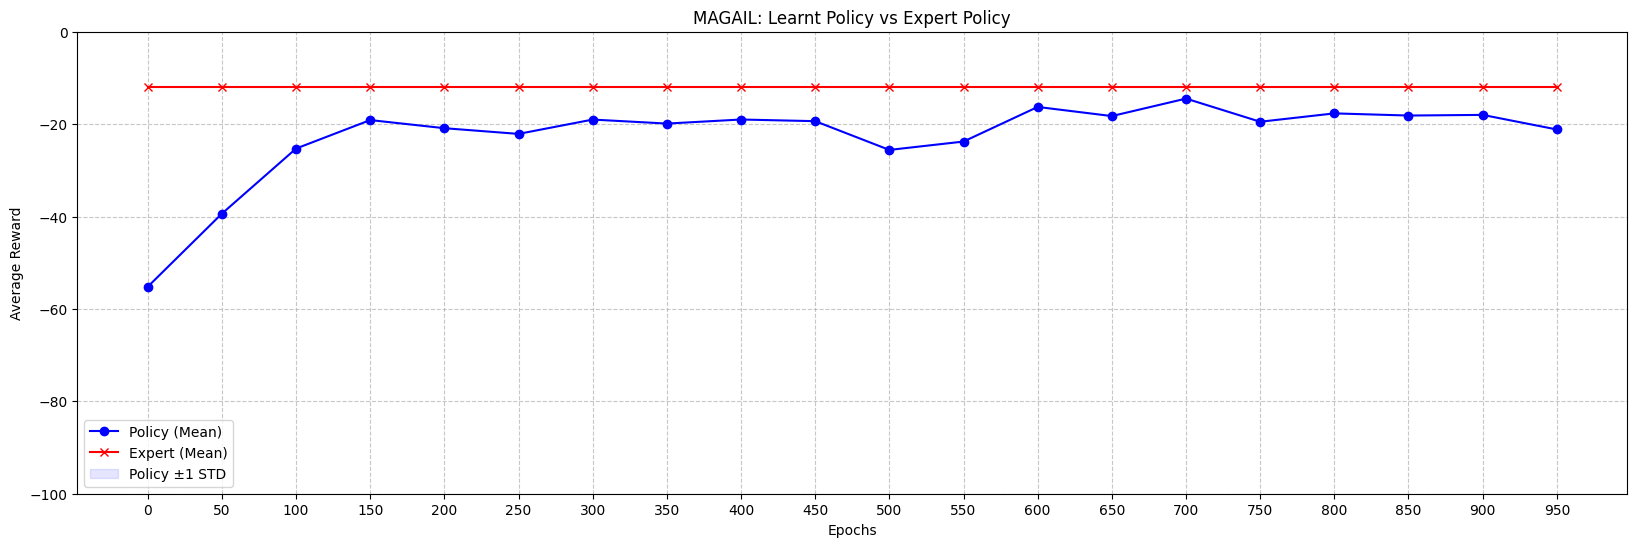

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from matplotlib import colors as mcolors

epochs = avg_df.index # X-axis: epochs (0, 50, 100, ...)

print(avg_df["episode_rewards"].dtype, avg_df["expert_rewards"].dtype, std_df["episode_rewards"].dtype)
print(avg_df["episode_rewards"].isna().sum(), avg_df["expert_rewards"].isna().sum(), std_df["episode_rewards"].isna().sum())

# Create the plot
plt.figure(figsize=(20, 6))
plt.plot(epochs, avg_df["episode_rewards"], label='Policy (Mean)', marker='o', color='blue')
plt.plot(epochs, avg_df["expert_rewards"], label='Expert (Mean)', marker='x', color='red')

# Plot shaded areas for standard deviation
plt.fill_between(epochs,
                 avg_df["episode_rewards"] - std_df["episode_rewards"],
                 avg_df["episode_rewards"] + std_df["episode_rewards"],
                 alpha=0.1, color='blue', label='Policy ±1 STD')

# Customize the plot
plt.xlabel('Epochs')
plt.ylabel('Average Reward')
plt.title('MAGAIL: Learnt Policy vs Expert Policy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(epochs)  # Show epoch numbers on x-axis

# Fix the y-axis
plt.ylim(-100, 0)

# Save plot
os.makedirs("plots", exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
save_path = f"plots/magail_{timestamp}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')


# Display the plot
plt.show()

In [54]:
# Create the plot
def plot_dianostics(array_mean, array_std, title):
    plt.figure(figsize=(20, 6))

    window_size = 50

    # Plot the window-averaged data
    plt.plot(range(0, len(array_mean) * window_size, window_size), array_mean, color='blue', marker='o', linewidth=2)

    # Plot shaded areas for standard deviation
    plt.fill_between(epochs,
                     array_mean - array_std,
                     array_mean + array_std,
                     alpha=0.05, color='blue', label='Policy ±1 STD')

    # Customize the plot
    plt.xlabel('Epochs')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(epochs)  # Show epoch numbers on x-axis

    # Fix the y-axis
    plt.ylim(-3, 1)

    # Display the plot
    plt.show()


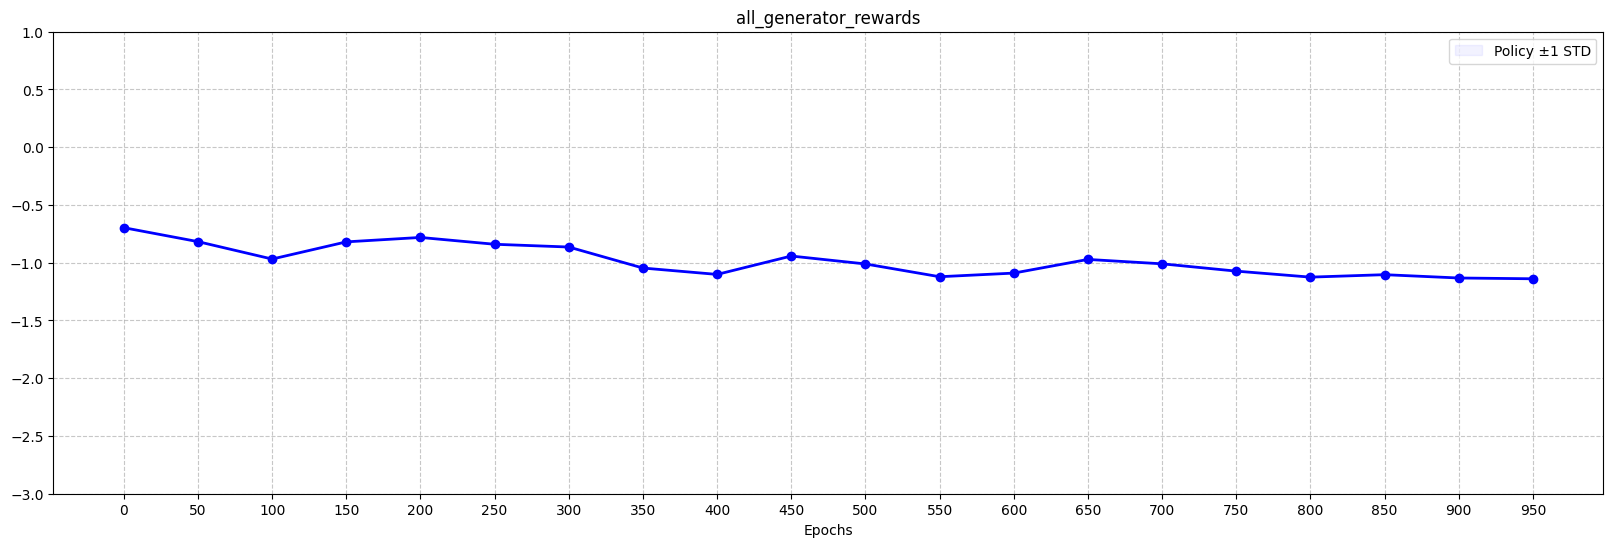

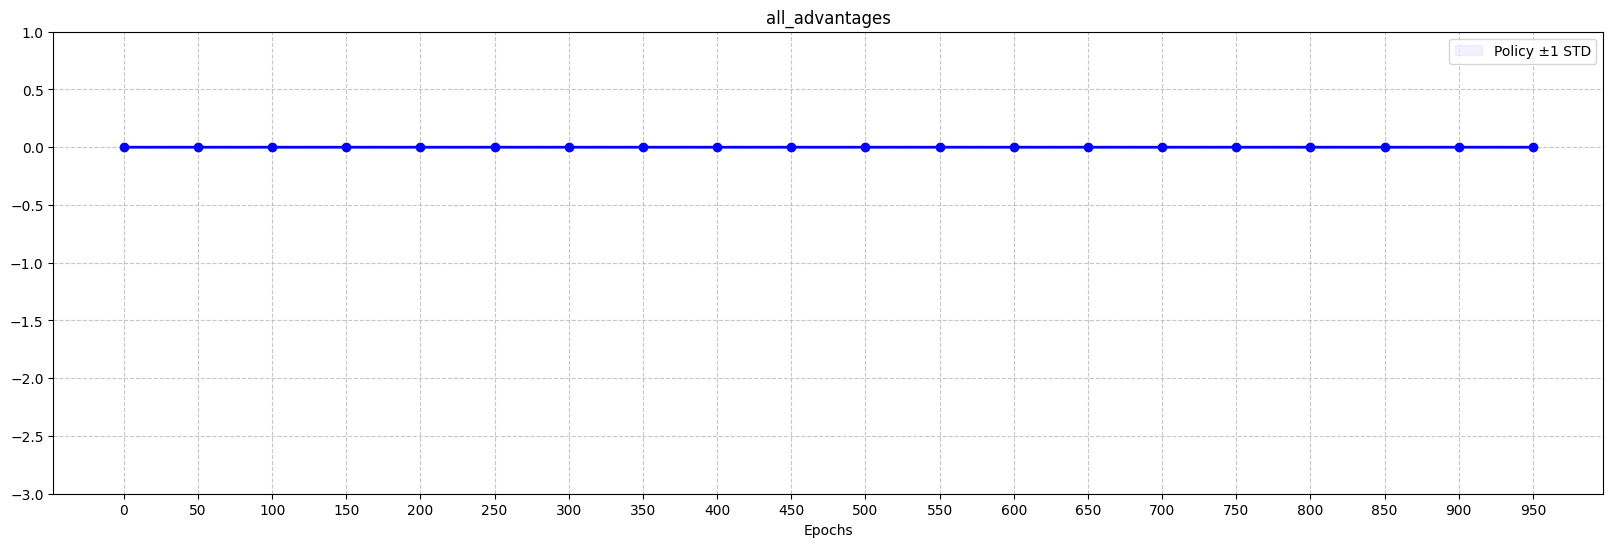

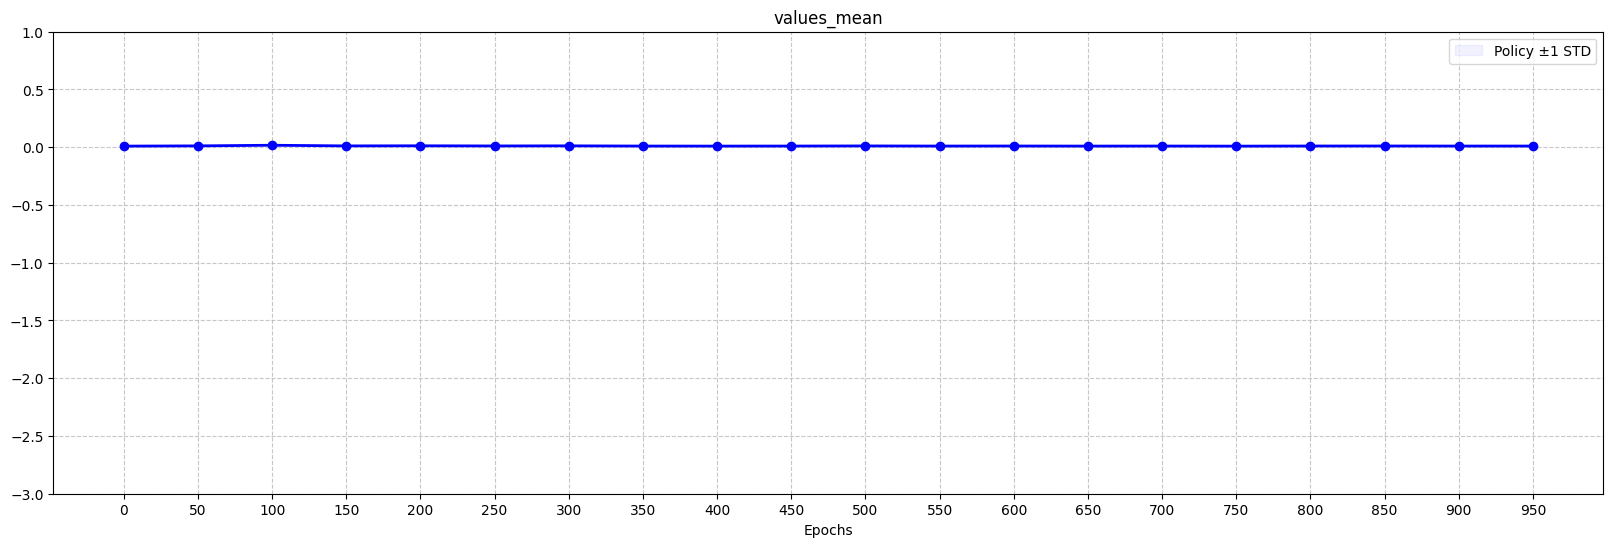

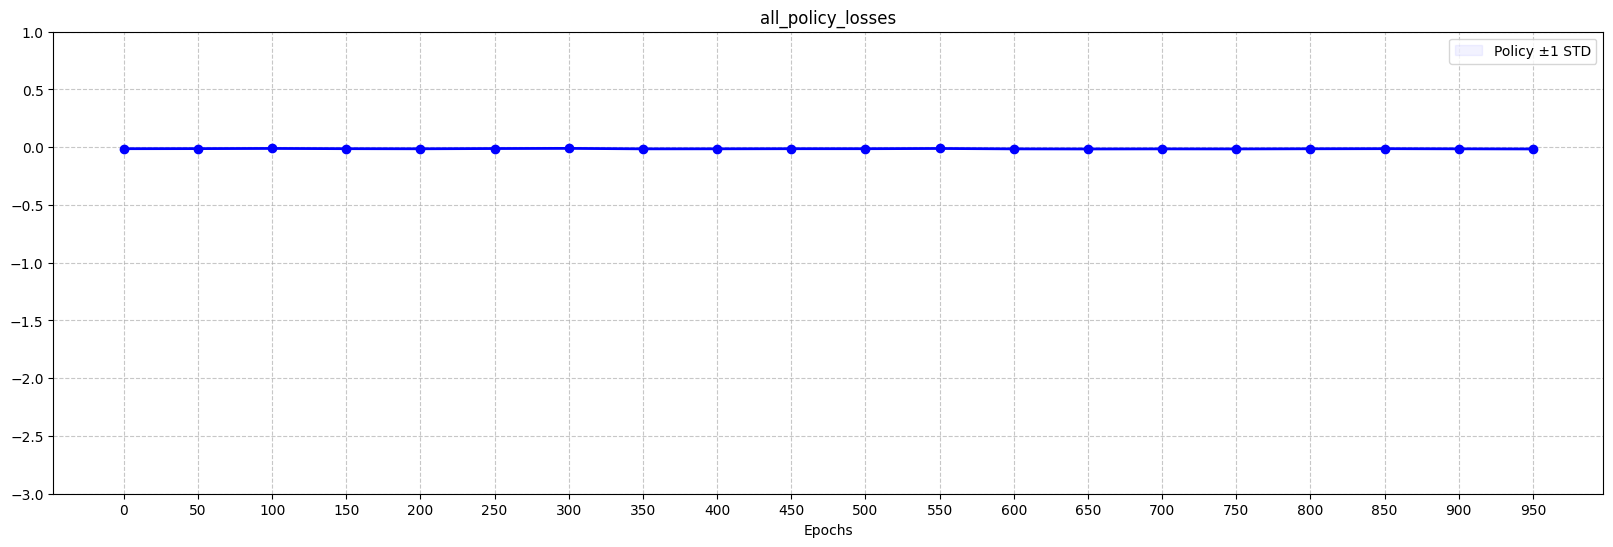

In [55]:
plot_dianostics(avg_df["generator_rewards"], std_df["generator_rewards"],"all_generator_rewards")
plot_dianostics(avg_df["advantages"], std_df["advantages"], "all_advantages")
plot_dianostics(avg_df["value_estimates"], std_df["value_estimates"], "values_mean")
plot_dianostics(avg_df["policy_losses"], std_df["policy_losses"], "all_policy_losses")

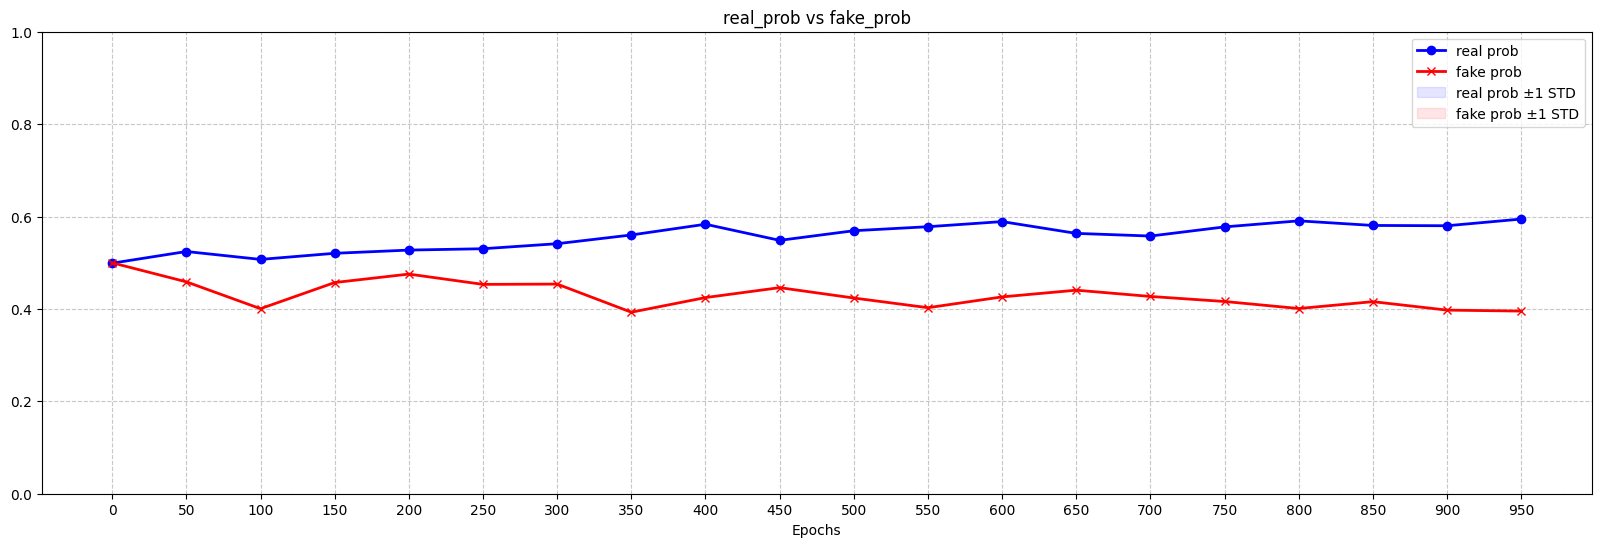

In [56]:
def plot_real_fake_prob(real_prob_means, real_prob_std, fake_prob_means, fake_prob_std, title):
    plt.figure(figsize=(20, 6))

    # Compute windowed means for every 50 epochs (non-overlapping)
    window_size = 50

    # Plot the window-averaged data
    plt.plot(range(0, len(real_prob_means) * window_size, window_size), real_prob_means, color='blue', marker='o', label="real prob", linewidth=2)
    plt.plot(range(0, len(fake_prob_means) * window_size, window_size), fake_prob_means, color='red', marker='x', label="fake prob", linewidth=2)

    # Plot shaded areas for standard deviation
    plt.fill_between(epochs,
                     real_prob_means - real_prob_std,
                     real_prob_means + real_prob_std,
                     alpha=0.1, color='blue', label='real prob ±1 STD')
    plt.fill_between(epochs,
                     fake_prob_means - fake_prob_std,
                     fake_prob_means + fake_prob_std,
                     alpha=0.1, color='red', label='fake prob ±1 STD')

    # Customize the plot
    plt.xlabel('Epochs')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.xticks(epochs)  # Show epoch numbers on x-axis

    # Fix the y-axis
    plt.ylim(0, 1)

    # Save plot
    os.makedirs("plots", exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    save_path = f"plots/{DISC_TYPE}_real_fake_prob_{timestamp}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()



plot_real_fake_prob(avg_df["disc_real_prob"], std_df["disc_real_prob"], avg_df["disc_fake_prob"], std_df["disc_fake_prob"], "real_prob vs fake_prob")